In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Hugging Face Pretrained Models
from transformers import AutoImageProcessor, ResNetForImageClassification

plt.style.use('seaborn-v0_8')
# Check that MPS acceleration
if not torch.backends.mps.is_available():
    print("MPS is not available on this system.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("mps")
    print(f"MPS is available on {device}.")

/opt/homebrew/anaconda3/envs/dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS is available on mps.


# Read in Data and convert to Numpy Array
- Could Probably Parallelize with spark?

In [3]:
# Read all images from the directory and convert them to a numpy array
def image_array(path):
    animals = sorted(os.listdir(path))
    pic_dict = {}
    for file in animals:
        if file.startswith('.'):
            continue
        imgs = os.listdir(os.path.join(path, file))
        new_animal = []
        for i in range(5):
            img = Image.open(os.path.join(path, file, imgs[i]))
            img = np.array(img)
            new_animal.append(img)
        pic_dict[file] = np.array(new_animal)
    return pic_dict

train_pics = image_array("./Training_Data/")
val_pics = image_array("./Validation_Data/")
train_pics['Butterfly'].shape

(5, 256, 256, 3)

# Preprocess Data For NN

In [4]:
# Training and Validation data
transforms = v2.Compose([
    v2.ToImage(), # Convert to PIL Image
    v2.Resize((224, 224)), # Resize to 224x224
    v2.RandomHorizontalFlip(), # Add Random Horizontal Flip
    v2.RandomVerticalFlip(), # Add Random Vertical Flip
    v2.RandomRotation(20), # Add Random Rotation
    v2.ToDtype(torch.float32, scale=True), # Convert to Float32
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])
val_transforms = v2.Compose([
    v2.ToImage(), # Convert to PIL Image
    v2.Resize((224, 224)), # Resize to 224x224
    v2.ToDtype(torch.float32, scale=True), # Convert to Float32
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

transformed_train = []
transformed_val = []


c = 0 
for i in train_pics.keys(): 
    for img in train_pics[i]:
        transformed_train.append((transforms(img),c))
    c+=1

c = 0 
for i in val_pics.keys(): 
    for img in val_pics[i]:
        transformed_val.append((val_transforms(img),c))
    c+=1

transformed_val[5]

(Image([[[-0.7650, -0.7479, -0.7137,  ...,  0.6906,  0.5536,  0.4337],
         [-0.7650, -0.7479, -0.7137,  ...,  0.6906,  0.5707,  0.4508],
         [-0.7479, -0.7308, -0.6965,  ...,  0.7248,  0.6049,  0.4851],
         ...,
         [-1.1418, -1.1418, -1.1418,  ..., -1.2959, -1.3130, -1.3302],
         [-1.1589, -1.1589, -1.1418,  ..., -1.3130, -1.3302, -1.3644],
         [-1.1589, -1.1589, -1.1589,  ..., -1.3302, -1.3644, -1.3815]],
 
        [[-0.9853, -0.9678, -0.9153,  ...,  0.2402,  0.1001, -0.0224],
         [-0.9853, -0.9503, -0.9153,  ...,  0.2402,  0.1176, -0.0049],
         [-0.9678, -0.9503, -0.8978,  ...,  0.2752,  0.1527,  0.0301],
         ...,
         [-1.2479, -1.2479, -1.2654,  ..., -1.2829, -1.3004, -1.3179],
         [-1.2654, -1.2654, -1.2654,  ..., -1.3004, -1.3179, -1.3529],
         [-1.2654, -1.2654, -1.2829,  ..., -1.3179, -1.3529, -1.3704]],
 
        [[-0.8807, -0.8807, -0.8633,  ..., -0.1835, -0.3230, -0.4450],
         [-0.8807, -0.8633, -0.8633,  ..., 

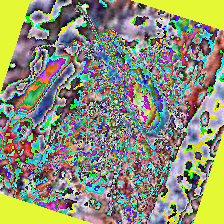

In [5]:
# Show the image from numpy array
img = transformed_train[0][0].permute(1, 2, 0).numpy()
Image.fromarray((img * 255).astype(np.uint8))

In [60]:
# Training and Validation data
transforms = v2.Compose([
    v2.ToImage(), # Convert to PIL Image
    v2.Resize((224, 224)), # Resize to 224x224
    v2.RandomHorizontalFlip(), # Add Random Horizontal Flip
    v2.RandomVerticalFlip(), # Add Random Vertical Flip
    v2.RandomRotation(20), # Add Random Rotation
    v2.ToDtype(torch.float32, scale=True), # Convert to Float32
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])
val_transforms = v2.Compose([
    v2.ToImage(), # Convert to PIL Image
    v2.Resize((224, 224)), # Resize to 224x224
    v2.ToDtype(torch.float32, scale=True), # Convert to Float32
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

# Create Datasets for Training and Validation
PATH = './' # Change this to the path of the dataset
train_dataset = ImageFolder(PATH + 'Training_Data', transform=transforms)
val_dataset = ImageFolder(PATH + 'Validation_Data', transform=transforms)

Class 0 : Beetle


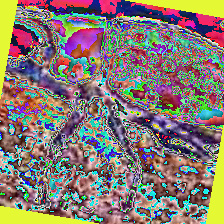

In [65]:
# View an example of the data
print('Class', train_dataset[0][1], 
      ':', train_dataset.classes[train_dataset[0][1]])
# Show the image from numpy array
img = train_dataset[0][0].permute(1, 2, 0).numpy()
Image.fromarray((img * 255).astype(np.uint8))

In [171]:
# Create a DataLoader for Training and Validation
train_dl = DataLoader(transformed_train, batch_size=32, shuffle=True)
val_dl = DataLoader(transformed_val, batch_size=32, shuffle=False)

In [172]:
# View the shapes of the data and batch
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [160]:
# Create a DataLoader for Training and Validation
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [161]:
# View the shapes of the data and batch
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Convolutional Neural Network

In [162]:
class ClassificationModel(nn.Module):
    def __init__(self, dropout=0.0, seed=1782, n_classes=10, device='cpu'):
        
        super(ClassificationModel, self).__init__()
        torch.manual_seed(seed)
        self.device = device # Set the device
        # Convolutional Neural Network (Windows)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Max Ppooling
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(128*28*28, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        # Convolutional Neural Network
        x = self.conv(x)
        # Flatten the Tensor
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = self.fc(x)
        # Softmax - Multi-Class Classification
        x = F.softmax(x, dim=1)
        return x

# Create the model With Dropout (Randomly set 20% of the weights to 0)
model = ClassificationModel(dropout=0.2, seed=1782, n_classes=15, device=device)

# Training and Validation steps

In [163]:
def train_one_epoch(model, train_dl, optimizer):
    '''
    Training the Model for one epoch.
    Parameters:
        model : PyTorch Model to train
        train_dl : Training DataLoader
        optimizer : PyTorch Optimizer
    Returns:
        train_loss : Training Loss using Cross Entropy
    '''
    x, y = next(iter(train_dl))
    x = x.to(device)
    y = y.to(device)
    model.to(device)
    model.train()
    train_loss = 0
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    return train_loss

def validate(model, val_dl):
    '''
    Training the Model for one epoch.
    Parameters:
        model : PyTorch Model to train
        val_dl : Validation DataLoader
    Returns:
        val_loss : Validation Loss using Cross Entropy
        accuracy : Accuracy of the Model
    '''
    model.to(device)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            val_loss += loss.item()
            # Get the Predicted Class index
            _, predicted = torch.max(y_hat, 1)
            # print(predicted, y)
            total += y.size(0)
            # Calculate accurate predictions of this batch
            correct += (predicted == y).sum().item()
    return val_loss, correct / total

# Training Loop

In [164]:
def train(model, train_dl, val_dl, epoch=10, lr=0.001):
    train_losses = []
    val_losses = []
    val_accuracy = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for i in tqdm(range(epoch)):
        train_loss = train_one_epoch(model, train_dl, optimizer)
        val_loss, val_acc = validate(model, val_dl)
        print(f'Epoch {i+1}/{epoch} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
    return train_loss, val_loss, val_acc

In [165]:
train_loss, val_loss, val_acc = train(model, train_dl, val_dl, epoch=5, lr=0.001)

 20%|██        | 1/5 [00:18<01:14, 18.73s/it]

Epoch 1/5 Train Loss: 2.7078 Val Loss: 171.1834 Val Acc: 0.1000


 40%|████      | 2/5 [00:27<00:37, 12.64s/it]

Epoch 2/5 Train Loss: 2.6916 Val Loss: 171.1897 Val Acc: 0.1000


 60%|██████    | 3/5 [00:36<00:22, 11.06s/it]

Epoch 3/5 Train Loss: 2.6603 Val Loss: 171.1897 Val Acc: 0.1000


 80%|████████  | 4/5 [00:46<00:10, 10.64s/it]

Epoch 4/5 Train Loss: 2.7853 Val Loss: 171.1897 Val Acc: 0.1000


100%|██████████| 5/5 [00:55<00:00, 11.06s/it]

Epoch 5/5 Train Loss: 2.7853 Val Loss: 171.1897 Val Acc: 0.1000


# Let's Use Pretrained Models Now
- https://huggingface.co/docs/transformers/model_doc/resnet

In [9]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50", return_dict=False)
res_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
PATH = './' # Change this to the path of the dataset
train_pre = ImageFolder(PATH + 'Training_Data')
val_pre = ImageFolder(PATH + 'Validation_Data')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


- Pretrained model has many layers, but the one we are interested in is the classifier
- The model originally has 1000 classes, but we only have 15 classes so
we need to change the classifier to output 15 classes

In [167]:
res_model.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=1000, bias=True)
)

In [168]:
# Set the last layer to output 15 classes
res_model.classifier[1] = nn.Linear(in_features=2048, out_features=15, bias=True)
res_model.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=15, bias=True)
)

In [169]:
# Create Datasets for Training and Validation
PATH = './' # Change this to the path of the dataset
train_dataset = ImageFolder(PATH + 'Training_Data', transform=transforms)
val_dataset = ImageFolder(PATH + 'Validation_Data', transform=val_transforms)

# Create a DataLoader for Training and Validation
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [170]:
class PretrainedModel(nn.Module):
    def __init__(self, seed=1782, model=None, device='cpu'):
        '''
        Set the Pretrained Model
        Parameters:
            seed : Random Seed
            model : Pretrained Model
            device : Device to use
        '''
        super(PretrainedModel, self).__init__()
        torch.manual_seed(seed)
        if model is None:
            return "Model is None"
        self.layer1 = model.to(device)
        self.device = device

    def forward(self, x):
        '''
        Forward Pass of the Model
        '''
        x = self.layer1(x)
        return x

In [171]:
def train_one_epoch_pre(model, train_dl, optimizer):
    '''
    Training the Model for one epoch.
    Parameters:
        model : PyTorch Model to train
        train_dl : Training DataLoader
        optimizer : PyTorch Optimizer
    Returns:
        train_loss : Training Loss using Cross Entropy
        train_acc : Accuracy of the Model
    '''
    x, y = next(iter(train_dl))
    x = x.to(device)
    y = y.to(device)
    model.to(device)
    model.train()
    train_loss = 0
    y_hat = model(x).logits
    #print(y_hat)
    loss = F.cross_entropy(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc = (y_hat.argmax(1) == y).sum().item() / y.size(0)
    return train_loss, train_acc

def validate_pre(model, val_dl):
    '''
    Training the Model for one epoch.
    Parameters:
        model : PyTorch Model to train
        val_dl : Validation DataLoader
    Returns:
        val_loss : Validation Loss using Cross Entropy
        accuracy : Accuracy of the Model
    '''
    model.to(device)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x).logits
            loss = F.cross_entropy(y_hat, y)
            val_loss += loss.item()
            # Get the Predicted Class index
            _, predicted = torch.max(y_hat, 1)
            # print(predicted, y)
            total += y.size(0)
            # Calculate accurate predictions of this batch
            correct += (predicted == y).sum().item()
    return val_loss, correct / total

In [172]:
def train(model, train_dl, val_dl, epoch=10, lr=0.001):
    '''
    Train the Model and record the Loss and Accuracy on the
    Training and Validation Data.
    Parameters:
        model : PyTorch Model to train
        train_dl : Training DataLoader
        val_dl : Validation DataLoader
        epoch : Number of Epochs
        lr : Learning Rate
    Returns:
        train_losses : List of Training Loss
        train_accuracy : List of Training Accuracy
        val_losses : List of Validation Loss
        val_accuracy : List of Validation Accuracy
    '''
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    # callbacks = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for i in tqdm(range(epoch)):
        train_loss, train_acc = train_one_epoch_pre(model, train_dl, optimizer)
        val_loss, val_acc = validate_pre(model, val_dl)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)
        if i % 10 == 0:
            print(f'Epoch {i+1}/{epoch}\n Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}\n Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

    return train_losses, train_accuracy, val_losses, val_accuracy

In [173]:
# Initialize the model with the ResNet50 Model
model = PretrainedModel(seed=1782, model=res_model, device=device)
# Train the Model
train_loss, train_accuracy, val_loss, val_acc = train(model, train_dl, val_dl, epoch=50, lr=0.001)

  2%|▏         | 1/50 [00:14<11:52, 14.54s/it]

Epoch 1/50
 Train Loss: 2.7208 Train Acc: 0.0938
 Val Loss: 170.4182 Val Acc: 0.0940


 22%|██▏       | 11/50 [02:02<07:07, 10.95s/it]

Epoch 11/50
 Train Loss: 2.4360 Train Acc: 0.3125
 Val Loss: 150.6081 Val Acc: 0.5500


 42%|████▏     | 21/50 [03:53<05:20, 11.05s/it]

Epoch 21/50
 Train Loss: 1.7734 Train Acc: 0.7188
 Val Loss: 100.4998 Val Acc: 0.7940


 62%|██████▏   | 31/50 [05:44<03:32, 11.21s/it]

Epoch 31/50
 Train Loss: 0.9088 Train Acc: 0.8125
 Val Loss: 43.6472 Val Acc: 0.8305


 82%|████████▏ | 41/50 [07:33<01:36, 10.73s/it]

Epoch 41/50
 Train Loss: 0.7362 Train Acc: 0.8438
 Val Loss: 24.3453 Val Acc: 0.8975


100%|██████████| 50/50 [09:10<00:00, 11.02s/it]


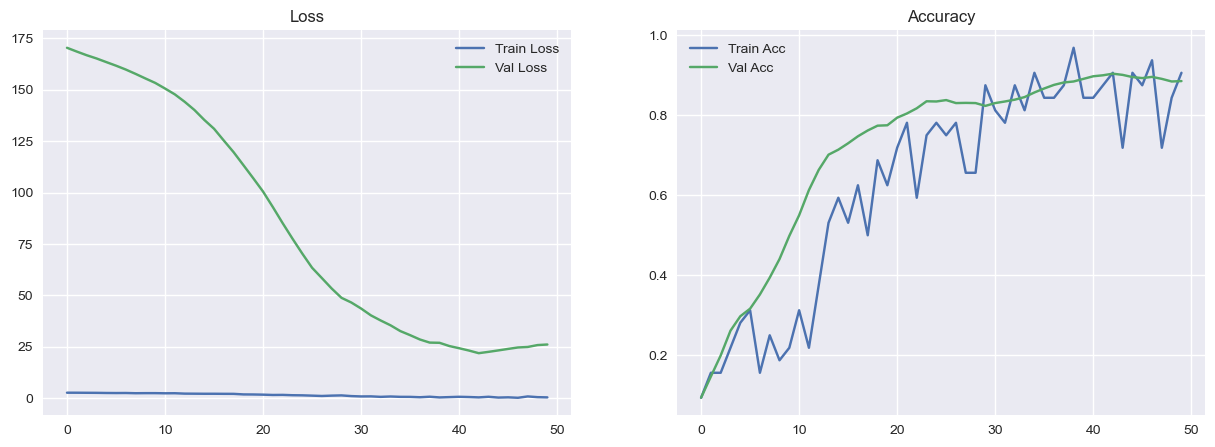

In [174]:
# Plot the Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(val_loss, label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_accuracy, label='Train Acc')
ax[1].plot(val_acc, label='Val Acc')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

# See 5 Model Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


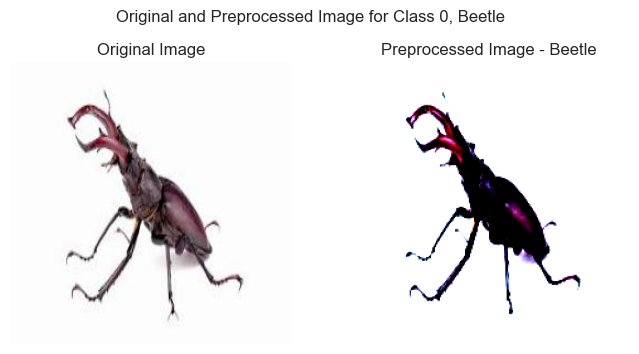

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


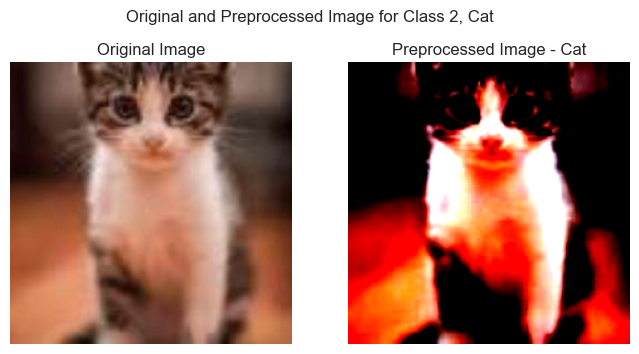

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


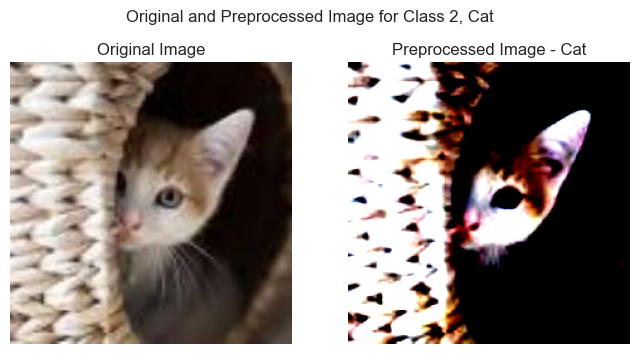

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


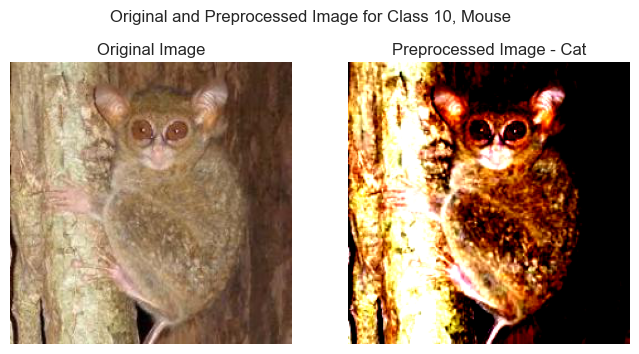

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


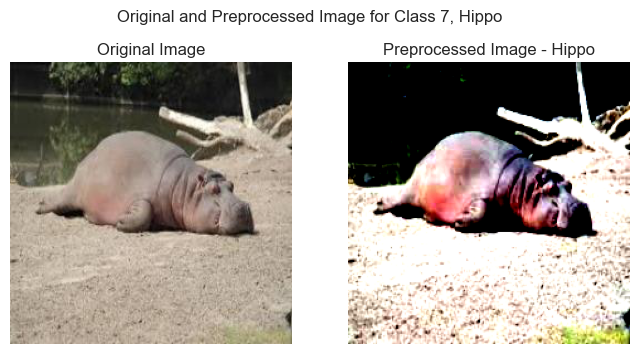

In [175]:
example_image = ImageFolder(PATH + 'Validation_Data')
# View an example of the data
for _ in range(5):
    random_index = np.random.randint(0, len(example_image))
    class_idx = example_image[random_index][1]
    true_class = example_image.classes[example_image[random_index][1]]
    # Show the image from numpy array
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(example_image[random_index][0])
    ax[0].set_title('Original Image')
    # Get preprocess the Image
    image = val_dataset[random_index][0].unsqueeze(0)
    # Predict the Image
    model.to(device)
    model.eval()
    with torch.no_grad():
        y_hat = model(image.to(device)).logits
        _, predicted = torch.max(y_hat, 1)
        prediction = example_image.classes[predicted.item()]
    ax[1].imshow(image.squeeze(0).permute(1, 2, 0).numpy())
    ax[1].set_title(f'Preprocessed Image - {prediction}')
    ax[0].axis('off')
    ax[1].axis('off')
    fig.suptitle((f'Original and Preprocessed Image for Class {class_idx}, {true_class}'))
    plt.show()